In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose

In [29]:
sol = pd.read_csv('SOL_Yearly.csv')
sol = sol[['NAME_1','ntl_sum','date']]

In [30]:
sol['date'] = pd.to_datetime(sol['date'])
df = sol.pivot_table(index='date', columns='NAME_1', values='ntl_sum', aggfunc='max')
df = df.drop(columns=['Andaman and Nicobar', 'Dadra and Nagar Haveli', 'Daman and Diu', 'Lakshadweep', 'Puducherry'])
df.reset_index(inplace=True)
# df.to_csv('Statewise_yearly.csv', index=False)

In [31]:
# df = pd.read_csv('Statewise_yearly.csv')
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df.head()
# for column in df.columns[1:]:
#     plt.figure(figsize=(10, 6))
#     plt.plot(df['date'], df[column])
#     plt.title(column)
#     plt.xlabel('Date')
#     plt.ylabel('Sum of Lights')
#     plt.xticks(rotation=45)
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()

NAME_1,Andhra Pradesh,Arunachal Pradesh,Assam,Bihar,Chandigarh,Chhattisgarh,Goa,Gujarat,Haryana,Himachal Pradesh,...,Odisha,Punjab,Rajasthan,Sikkim,Tamil Nadu,Telangana,Tripura,Uttar Pradesh,Uttarakhand,West Bengal
date,,,,,,,,,,,,,,,,,,,,,
2012-01-19,393656.31250,9531.467773,188560.250000,189780.437500,12749.593750,329670.06250,26613.685547,699597.1250,391111.65625,76887.007812,...,344940.15625,406058.34375,9.071202e+05,8249.839844,647359.1250,503304.3125,33123.242188,1206751.625,152595.078125,504715.96875
2013-01-19,360345.71875,5306.039551,179864.937500,174662.609375,12840.736328,347165.00000,28172.673828,647683.0625,469774.68750,54618.925781,...,348911.31250,434336.43750,8.896389e+05,7222.919434,644206.9375,489869.1250,35516.968750,1165377.750,134539.484375,518444.62500
2014-01-19,423416.53125,6929.722656,239659.468750,314598.093750,13736.635742,394821.25000,27461.277344,765016.3125,517798.40625,68422.335938,...,423708.28125,438643.25000,1.075784e+06,7766.735840,725702.2500,535541.6875,42239.121094,1403249.625,147398.234375,590858.43750
2015-01-19,438082.65625,7442.071777,263255.156250,405187.093750,14106.319336,411545.03125,27855.873047,802619.5625,428374.21875,57752.046875,...,444590.90625,414915.43750,1.068710e+06,7324.320312,739620.8750,553463.1250,43508.593750,1366555.250,142667.281250,624750.00000
2016-01-19,395831.00000,5764.720215,225036.828125,456406.281250,14486.238281,368148.06250,27472.388672,787392.2500,409779.68750,49158.312500,...,398530.68750,416861.71875,1.005114e+06,6002.750488,733120.3125,523715.1250,38334.757812,1602459.250,131403.859375,596846.18750


In [32]:
def extract_trend_features(data):
    
    decomposition = seasonal_decompose(data, model='additive', period=1)

    trend = decomposition.trend.dropna()  
      
    slope = (trend.iloc[-1] - trend.iloc[0]) / len(trend)  
    
    return [trend.mean(),trend.std(),slope]


mean_df, std_df, slope_df = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
for i in df.columns:
    if i !='date':
        df_state = df[i]
        mean_val, std_val, slope_val = extract_trend_features(df_state)
        
        mean_df[i] = [mean_val]
        std_df[i] = [std_val]
        slope_df[i] = [slope_val]

In [33]:
mean_df = mean_df.transpose()
mean_df.rename(columns={0: 'mean'}, inplace=True)

std_df = std_df.transpose()
std_df.rename(columns={0: 'std'}, inplace=True)

slope_df = slope_df.transpose()
slope_df.rename(columns={0: 'slope'}, inplace=True)

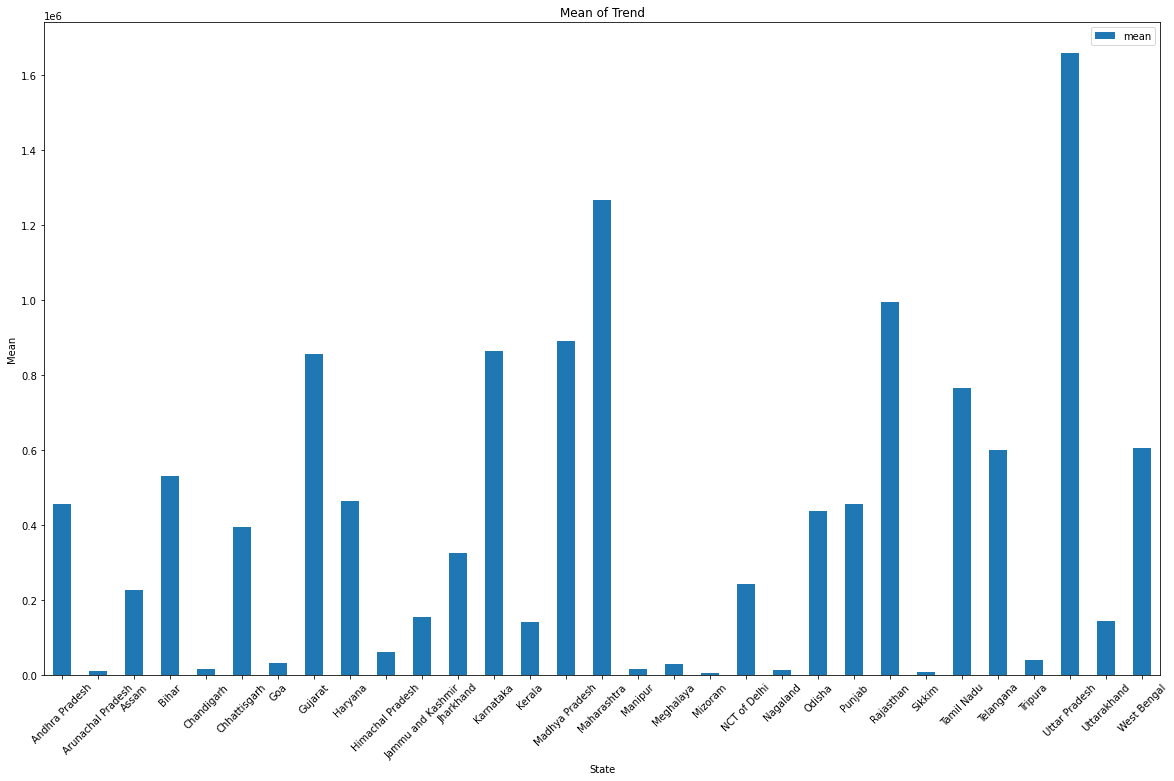

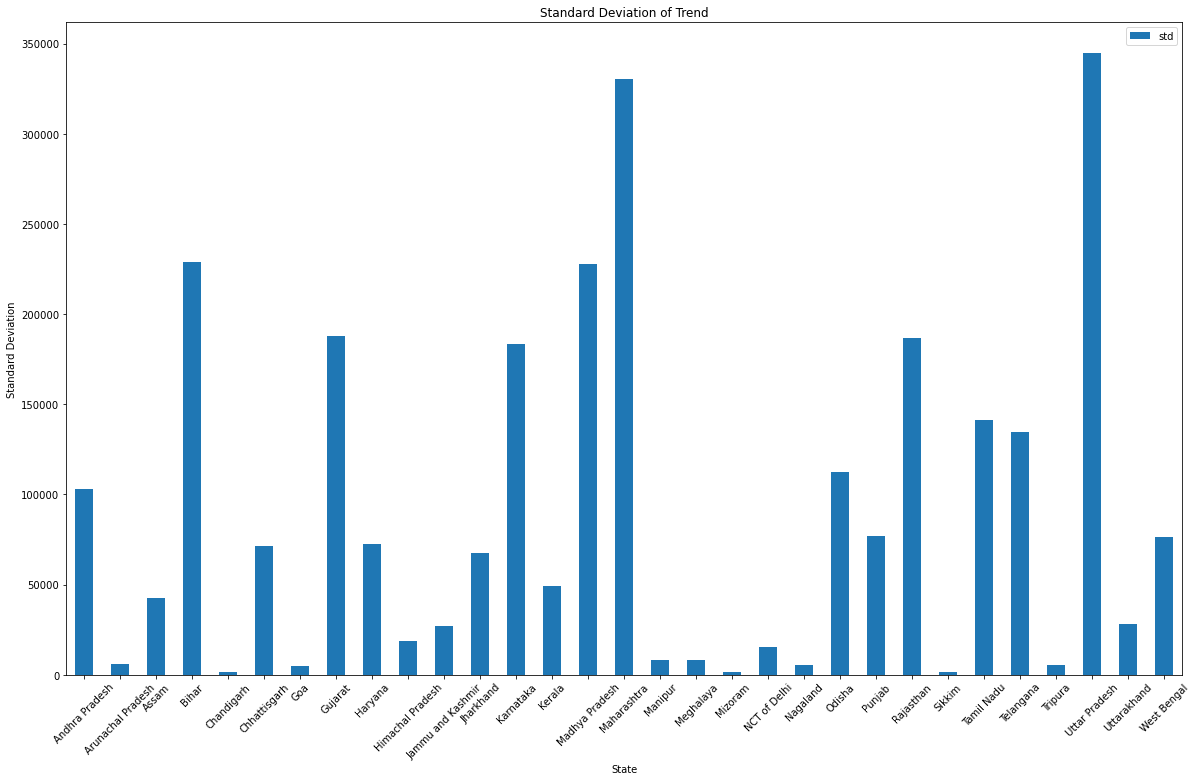

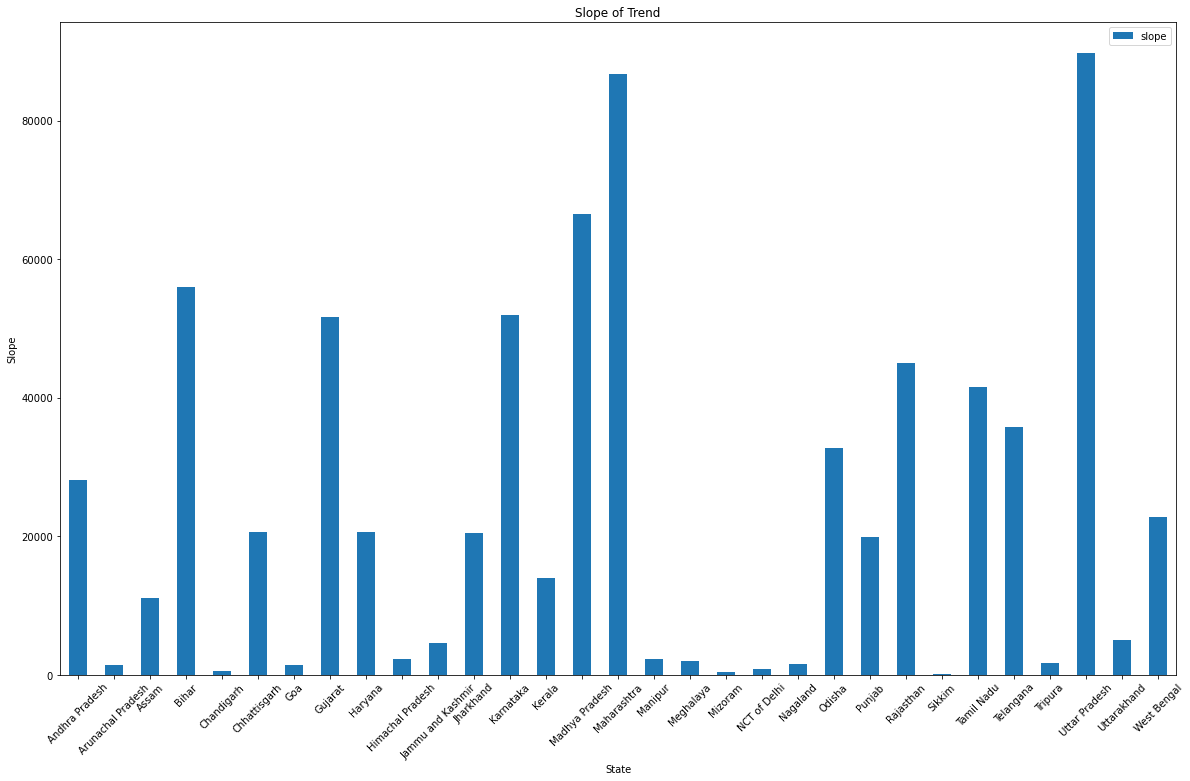

In [34]:
# Plot mean
mean_df.plot(kind='bar', figsize=(20, 12), title='Mean of Trend')
plt.xlabel('State')
plt.ylabel('Mean')
plt.xticks(rotation=45)
plt.show()

# Plot standard deviation
std_df.plot(kind='bar', figsize=(20, 12), title='Standard Deviation of Trend')
plt.xlabel('State')
plt.ylabel('Standard Deviation')
plt.xticks(rotation=45)
plt.show()

# Plot slope
slope_df.plot(kind='bar', figsize=(20, 12), title='Slope of Trend')
plt.xlabel('State')
plt.ylabel('Slope')
plt.xticks(rotation=45)
plt.show()

In [35]:
def cluster_analysis(input_df):

    # Assuming you have 'mean_df' DataFrame containing the mean values

    # Choose the range of clusters to evaluate
    min_clusters = 2
    max_clusters = 10
    cluster_range = range(min_clusters, max_clusters + 1)

    # Initialize lists to store silhouette scores and distortion scores (inertia)
    silhouette_scores = []
    distortion_scores = []

    # Iterate over different numbers of clusters
    for num_clusters in cluster_range:
        # Perform KMeans clustering
        kmeans = KMeans(n_clusters=num_clusters, random_state=42)
        kmeans.fit(input_df)
        
        # Get cluster labels and calculate silhouette score
        cluster_labels = kmeans.labels_
        silhouette_avg = silhouette_score(input_df, cluster_labels)
        silhouette_scores.append(silhouette_avg)
        
        # Calculate distortion score (inertia)
        distortion_scores.append(kmeans.inertia_)

    # Plot silhouette scores
    plt.figure(figsize=(10, 5))
    plt.plot(cluster_range, silhouette_scores, marker='o')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score vs. Number of Clusters')
    plt.xticks(cluster_range)
    plt.grid(True)
    plt.show()

    # Plot elbow curve (distortion scores)
    plt.figure(figsize=(10, 5))
    plt.plot(cluster_range, distortion_scores, marker='o')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Distortion Score (Inertia)')
    plt.title('Elbow Curve: Distortion Score vs. Number of Clusters')
    plt.xticks(cluster_range)
    plt.grid(True)
    plt.show()

    return silhouette_scores.index(max(silhouette_scores))+2


In [36]:
def assigning_cluster(n, input_df):
    num_clusters = n
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)

    kmeans.fit(input_df)

    cluster_labels = kmeans.labels_

    input_df['cluster'] = cluster_labels

    cluster_counts = input_df['cluster'].value_counts()
    print("Cluster Counts:")
    print(cluster_counts)

    cluster_means = input_df.groupby('cluster').mean()
    print("\nCluster Means:")
    print(cluster_means)

    return input_df

In [37]:
def plot_clusters(input_df):
    cluster_groups = input_df.groupby('cluster')
    # Plot each cluster
    plt.figure(figsize=(20,12))
    for cluster_label, group_data in cluster_groups:
        plt.barh(group_data.index, group_data.iloc[:,0], label=f'Cluster {cluster_label}')

    # Add labels and title
    plt.xlabel('Mean')
    plt.ylabel('State')
    plt.title('Cluster')
    plt.legend()
    plt.show()

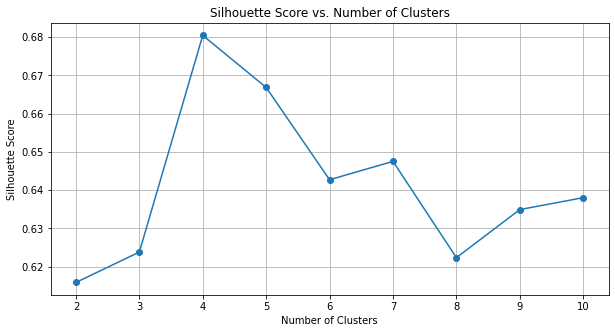

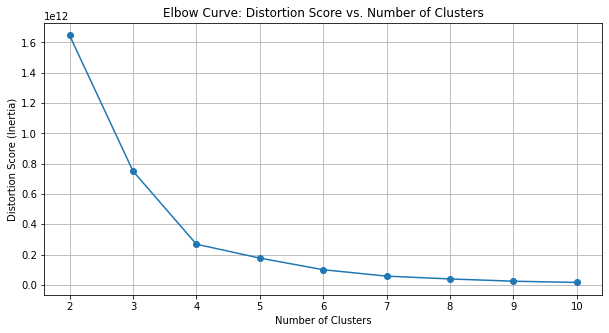

Cluster Counts:
0    15
2     9
1     5
3     2
Name: cluster, dtype: int64

Cluster Means:
                 mean
cluster              
0        7.517832e+04
1        8.744072e+05
2        4.740646e+05
3        1.462953e+06


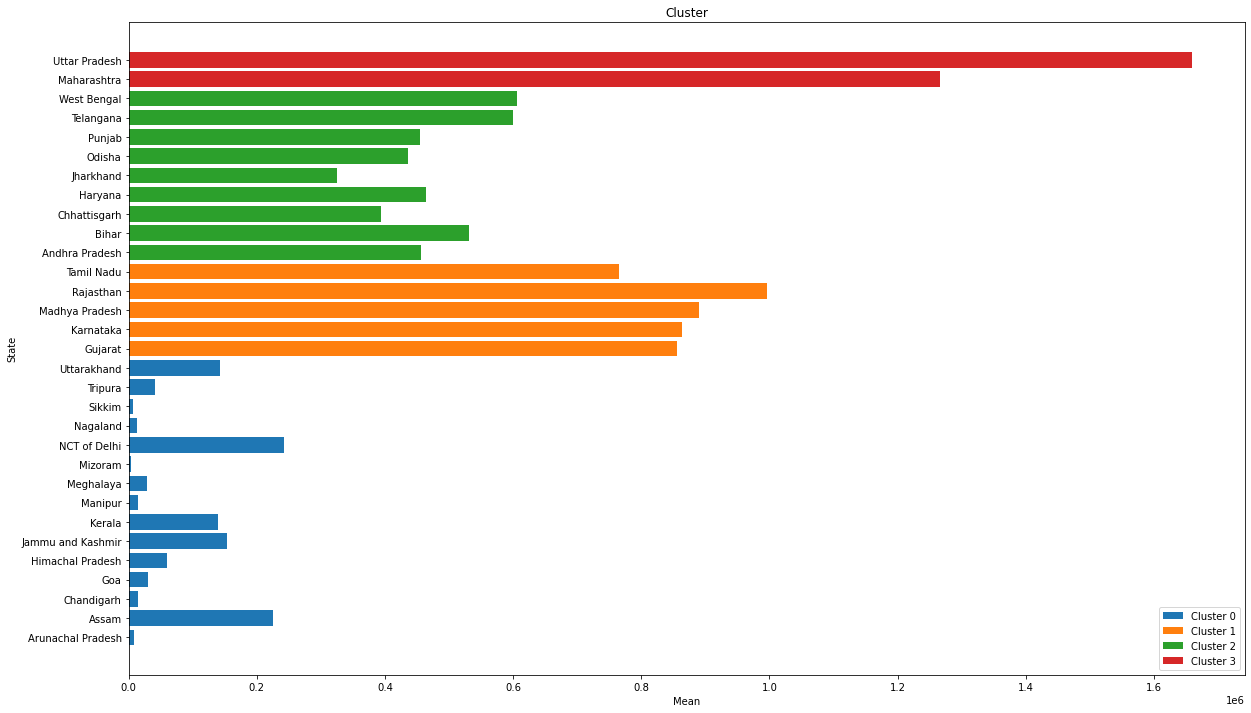

In [38]:
sh_score = cluster_analysis(mean_df)
mean_df = assigning_cluster(4, mean_df)
plot_clusters(mean_df)

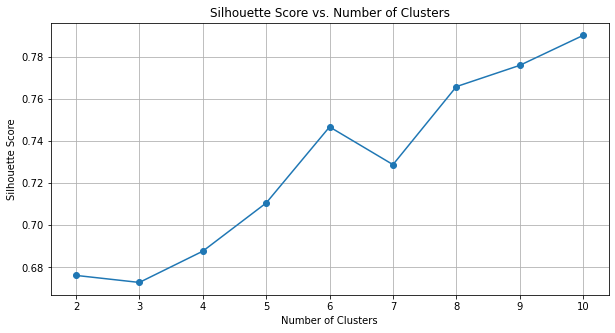

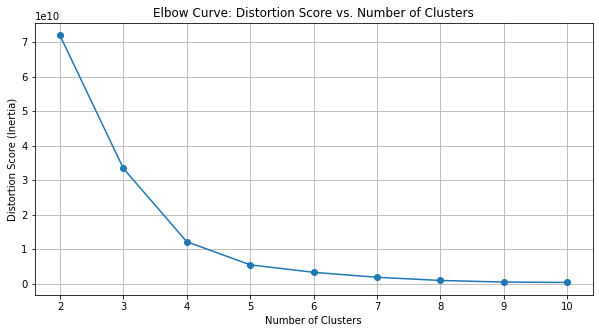

Cluster Counts:
0    15
3     9
1     5
2     2
Name: cluster, dtype: int64

Cluster Means:
                   std
cluster               
0         14840.912068
1        202840.223242
2        337563.783652
3         95027.850890


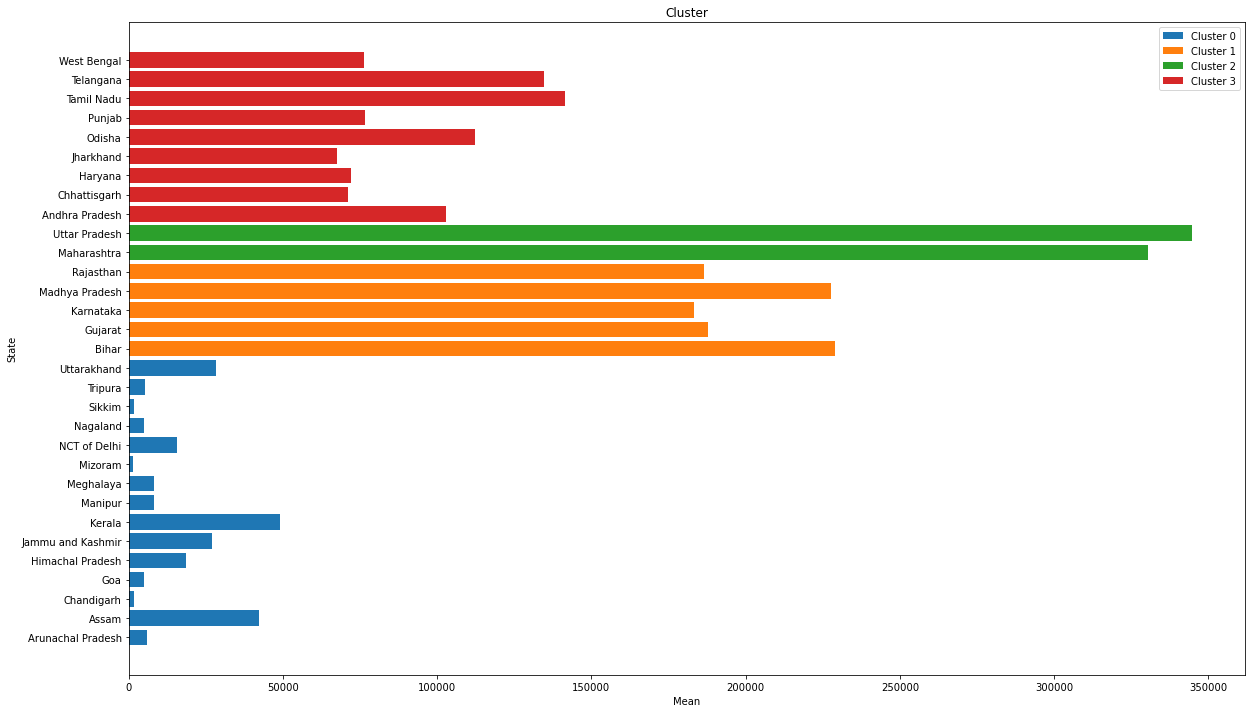

In [39]:
sh_score = cluster_analysis(std_df)
std_df = assigning_cluster(4, std_df)
plot_clusters(std_df)

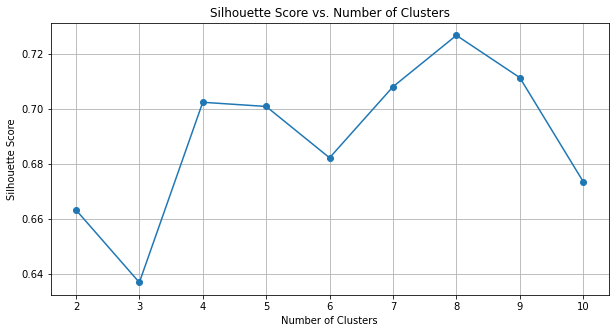

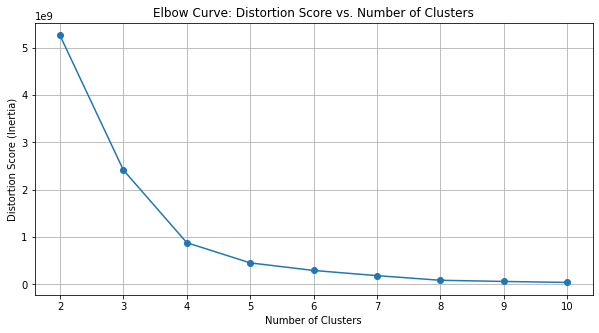

Cluster Counts:
0    14
2     9
1     6
3     2
Name: cluster, dtype: int64

Cluster Means:
                slope
cluster              
0         2512.811255
1        52117.621528
2        23865.694806
3        88197.268229


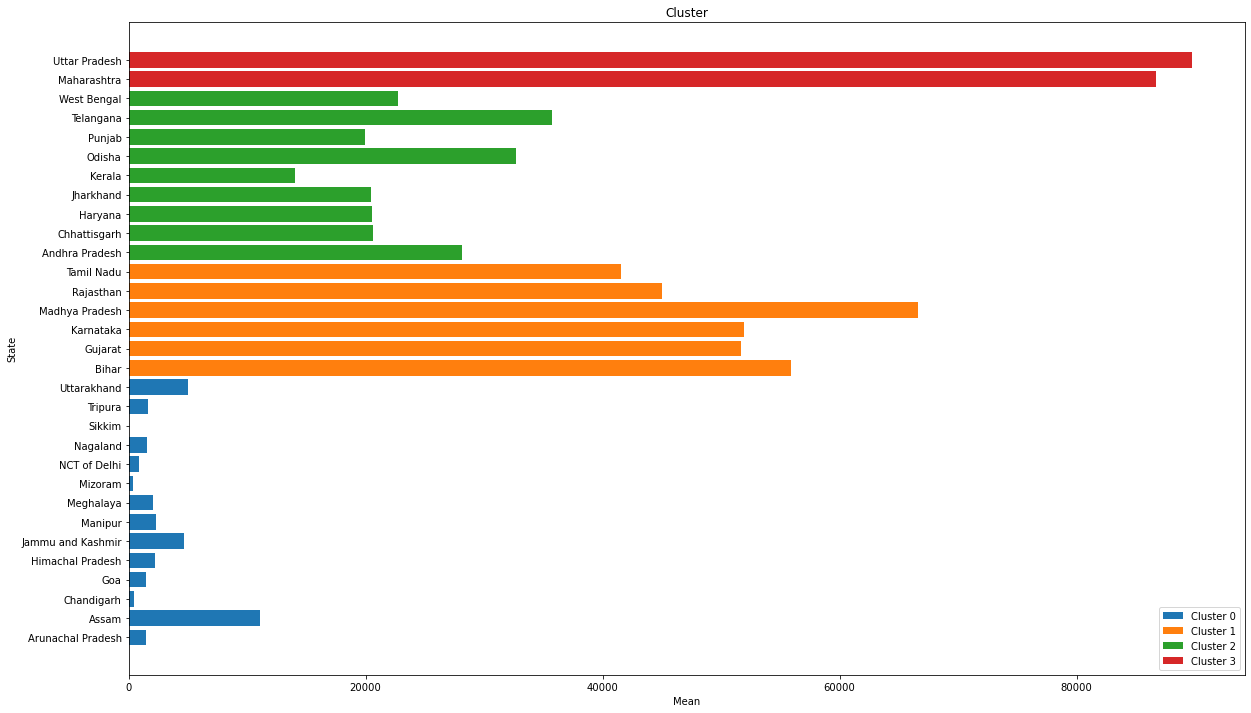

In [40]:
sh_score = cluster_analysis(slope_df)
slope_df = assigning_cluster(4, slope_df)
plot_clusters(slope_df)